# 0. Setup

In [124]:
import nilearn
import pandas as pd
import numpy as np
import os

from nilearn import plotting
from nilearn import connectome
from nilearn import datasets
from nilearn import image



In [147]:
# Set the path to the data directory
src_dir = '../data'

# Set the participant and session IDs
part_id = 'sub-02'
ses_id = 'ses-01'

# Path to the T1w image
anat_path = os.path.join(src_dir, part_id, ses_id, 'anat', f'{part_id}_{ses_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')

# Path to functional image
funcdir_path = os.path.join(src_dir, part_id, ses_id, 'func')

## 0.1 Anat

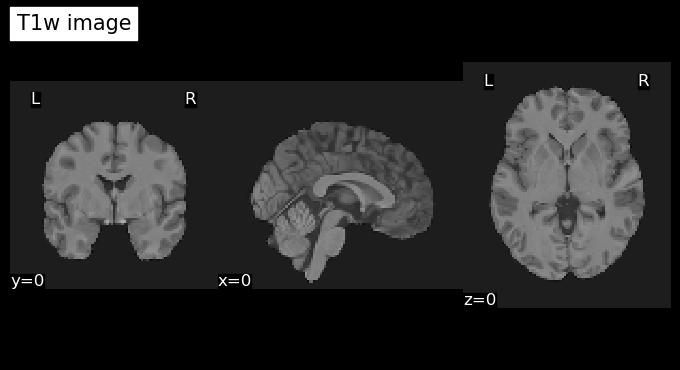

In [148]:
from nilearn.plotting import plot_anat

plot_anat(anat_path, title='T1w image', display_mode='ortho',  draw_cross=False,  cut_coords=(0, 0, 0))


In [149]:
# load the functional data

# list directory contents with extension 'nii.gz'
func_runs = os.listdir(funcdir_path)
func_runs = [f for f in func_runs if f.endswith('bold.nii.gz')]

# Sort the list
func_runs.sort()

print(func_runs)

['sub-02_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-02_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-02_ses-01_task-02a_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-02_ses-01_task-02a_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz']


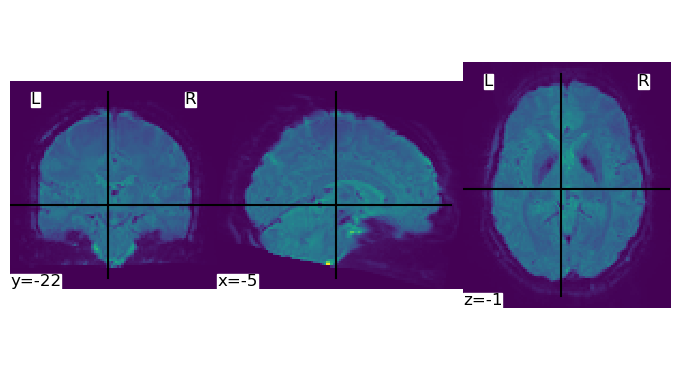

In [150]:
from nilearn.image import mean_img , load_img
from nilearn.plotting import plot_img

# Load the first functional image
func_image = image.load_img(os.path.join(funcdir_path,func_runs[0]))

mfunc_img = mean_img(func_image)

plot_img(mfunc_img)

# 1. Load Mask / atlas / meta

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

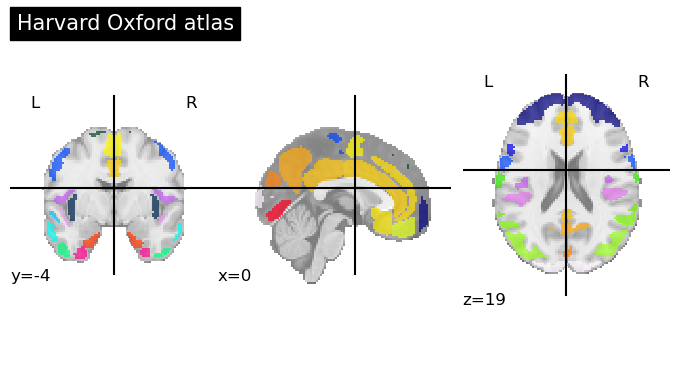

In [151]:
# load atlas
from nilearn import datasets
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas_filename = atlas.maps

# list of labels
labels = atlas.labels

print(labels)

# number of regions
number_of_regions = len(labels[1:])
print(number_of_regions)

# plot the atlas
from nilearn import plotting
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

# 2. Extract timecourses per ROI / block

In [152]:
# extract time series from ROIs
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache')

# time_series = masker.fit_transform(func_image)


In [153]:
fdir_events = [file for file in os.listdir(funcdir_path) if file.endswith('.tsv')]

f_events = [os.path.join(funcdir_path, f) for f in fdir_events]

f_events.sort()

print(f_events)


['../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-1_events.tsv', '../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-2_events.tsv', '../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-3_events.tsv', '../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-4_events.tsv']


# 3. Compute connectivity

In [132]:
from nilearn.image import index_img 


onset_set = {}
duration_set = {}

target_set = {}

group_set = {}


offset_st = 4 # offset for the onset time
offset_end = 2 # offset for the end block time

# Compute the correlation matrix and store it in the partial correlation matrix as a 4D array
conn_measure = connectome.ConnectivityMeasure(kind='correlation',
    standardize="zscore_sample",)

# intialize 2D array to store the partial correlation matrix 
partial_correlation_matrix = {}

run_id = 0
idx = 0

# for each events file 
for fn in f_events:

    print(os.path.join(funcdir_path,func_runs[run_id]), fn)

    # Load the events.tsv file
    events = pd.read_table(fn)

    # Load the corresponding functional image
    func_image = image.load_img(os.path.join(funcdir_path,func_runs[run_id]))

    # extract time course from functional image
    time_series = masker.fit_transform(func_image)

    # create one image per event 
    for i, row in events.iterrows():

        # Print the row information
        # print(row) 

        # Extract the onset time
        onset = np.round(row['onset'])

        # Extract the duration
        duration = np.round(row['duration'])

        # Extract the trial_type
        trial_type = row['trial_type']

        # Print the row information
        print(onset, duration, trial_type) 

        # if duration greater than 10 and not 'Noise'
        if duration > 10 and onset + duration + offset_end < 660 and trial_type != 'Noise':

            onset_set[idx] = onset + offset_st

            duration_set[idx] = duration - offset_st + offset_end

            target_set[idx] = trial_type

            group_set[idx] = run_id

            # Extract the time series for the event
            event_time_series = time_series[int(onset):int(onset + duration), :]

            
            # 2D array for the correlation matrix
            temp_correlation_matrix = conn_measure.fit_transform([event_time_series])[0]

            # vectorize the correlation matrix
            partial_correlation_matrix[idx] = temp_correlation_matrix.flatten()

            idx += 1

    run_id += 1




../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-1_events.tsv
0.0 12.0 Noise
12.0 24.0 Peacefulness
36.0 6.0 Noise
42.0 24.0 Peacefulness
66.0 18.0 Noise
84.0 24.0 Tenderness
108.0 6.0 Noise
114.0 24.0 Tenderness
138.0 18.0 Noise
156.0 24.0 Transcendence
180.0 6.0 Noise
186.0 24.0 Transcendence
210.0 18.0 Noise
228.0 24.0 JoyfulActivation
252.0 6.0 Noise
258.0 24.0 JoyfulActivation
282.0 18.0 Noise
300.0 24.0 Power
324.0 6.0 Noise
330.0 24.0 Power
354.0 18.0 Noise
372.0 24.0 Nostalgia
396.0 6.0 Noise
402.0 24.0 Nostalgia
426.0 18.0 Noise
444.0 24.0 Tension
468.0 6.0 Noise
474.0 24.0 Tension
498.0 18.0 Noise
516.0 24.0 Sadness
540.0 6.0 Noise
546.0 24.0 Sadness
570.0 18.0 Noise
588.0 24.0 Wonder
612.0 6.0 Noise
618.0 24.0 Wonder
642.0 18.0 Noise
../data/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-02

In [133]:
# Save the image_set, target_set, and group_set in the derivatives directory inside the data directory
deriv_dir = os.path.join(src_dir, 'derivatives')

if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)


# package folder structure
results_dir = os.path.join(deriv_dir, 'fc_mvpa')

if not os.path.exists(results_dir):
    os.makedirs(results_dir)


data_fldr= os.path.join(results_dir, part_id, ses_id)

# if the directory for the participant and session does not exist, create it
if not os.path.exists(data_fldr):
    os.makedirs(data_fldr)


# Save the partial correlation matrix to csv using pandas
pd.DataFrame(partial_correlation_matrix).T.to_csv(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_correlation-matrix.csv'))


# Save the target_set to csv using pandas
pd.Series(target_set, name = 'target').to_csv(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_targets.csv'))

# Save the group_set to csv using pandas
pd.Series(group_set, name = 'group').to_csv(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_groups.csv'))


## 3.1 Visualize average results per emotion

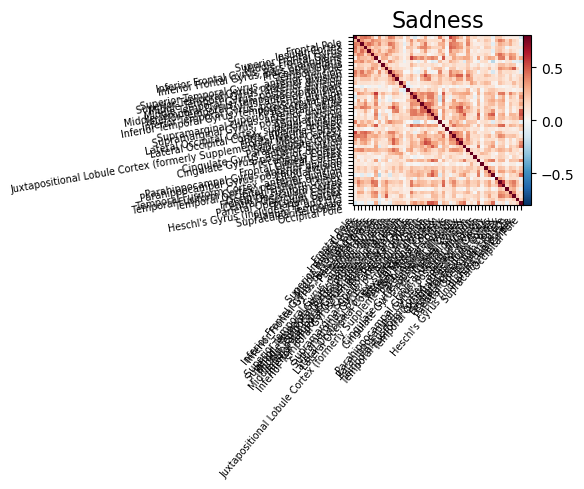

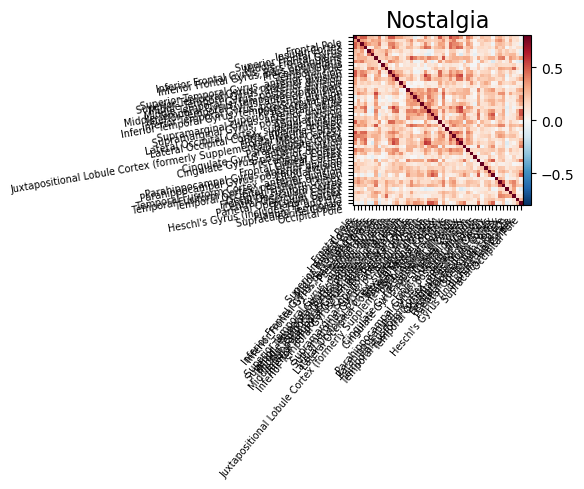

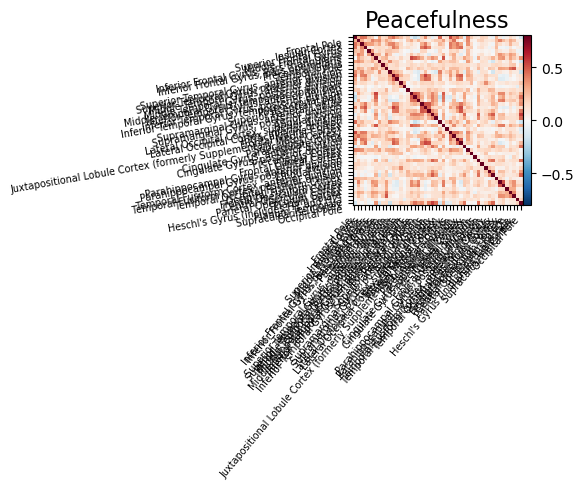

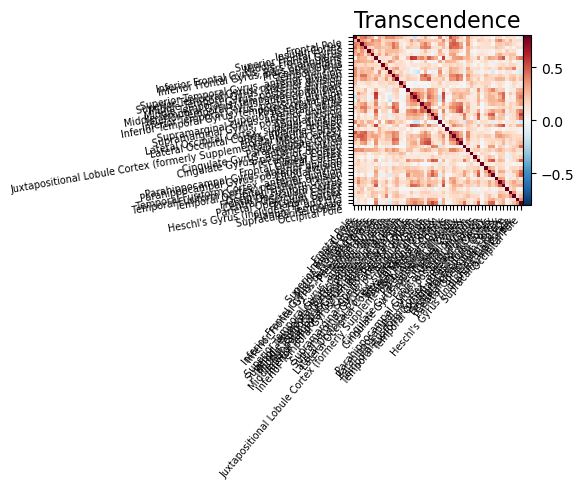

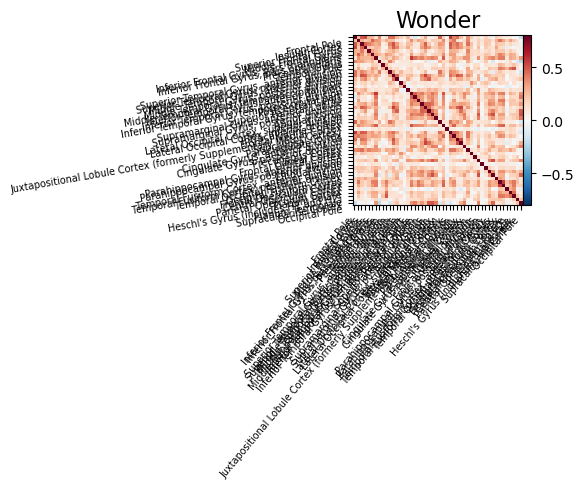

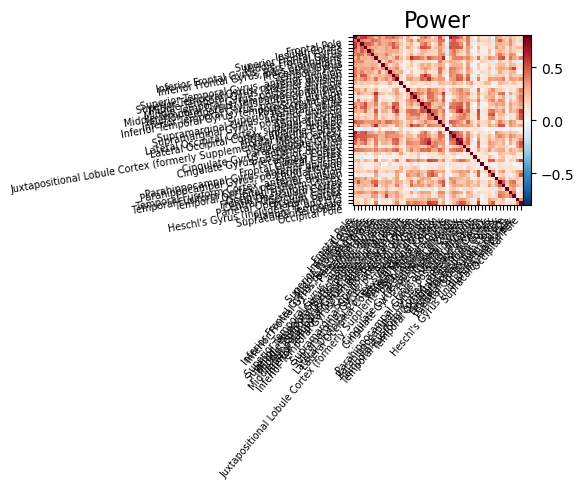

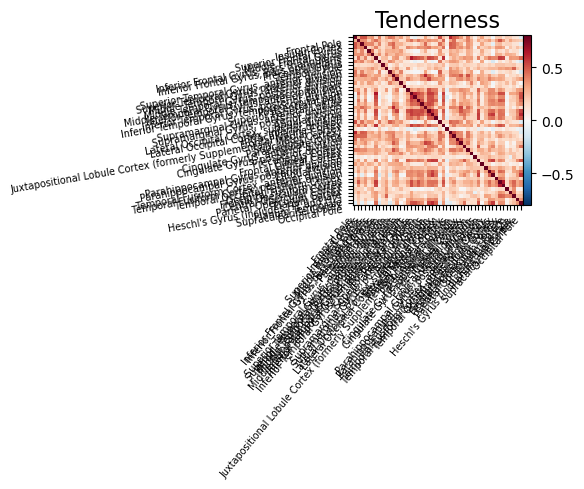

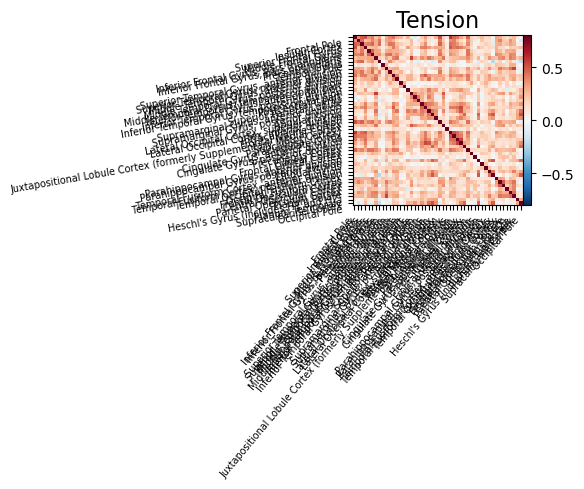

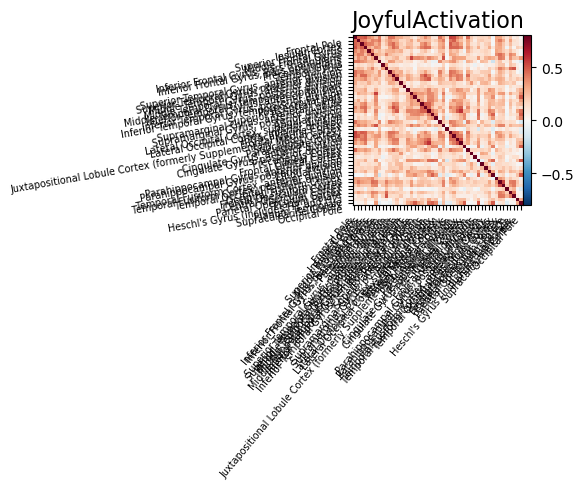

In [134]:
# Visualize the average correlation matrix for each type of event

for target in set(target_set.values()):
    
    # print(target)

    # Normalize the correlation matrix

    # Get the number of events for the target
    counter = 0

    fl_correlation_matrix = np.zeros((number_of_regions * number_of_regions))

    for key, value in target_set.items():


        if value == target:
            fl_correlation_matrix += partial_correlation_matrix[key]
            counter += 1


    fl_correlation_matrix /= counter

    TwoD_correlation_matrix = fl_correlation_matrix.reshape(number_of_regions,number_of_regions)
    # Plot the correlation matrix
    plotting.plot_matrix(TwoD_correlation_matrix, labels=labels[1:], vmax=0.8, vmin=-0.8, title=target)


    # Save the correlation matrix as a nifti file
    correlation_matrix_img = masker.inverse_transform(TwoD_correlation_matrix)

    # correlation_matrix_img.to_filename(f'correlation_matrix_{target}.nii.gz')



# 4. Compare emotions and save

In [135]:

# two-factorial anova analysis
# one factor is the type of event
# the other factor is the region

# create a dataframe to store the correlation matrix
df = pd.DataFrame(partial_correlation_matrix.values())

# add the target column
df['target'] = target_set.values()




In [136]:
# rename the columns
df.columns = [f'conn_{i}' for i in range(number_of_regions * number_of_regions)] + ['target']

In [137]:
# ANOVA analysis for each connection

from statsmodels.formula.api import ols

from statsmodels.stats.anova import anova_lm

# create a dictionary to store the results
results = {}

df = df.rename(columns={0: "conn0"})

for i in range(number_of_regions * number_of_regions):
    
        # create the formula
        formula = f'conn_{i} ~ C(target)'
    
        # create the model
        model = ols(formula, data=df).fit()
    
        # perform the ANOVA
        aov_table = anova_lm(model, typ=2)
    
        # store the results
        results[i] = aov_table
    

/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_25032/663876519.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_matrix[i,j] = results[i * number_of_regions + j]['PR(>F)'][0]
/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_25032/663876519.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[i * number_of_regions + j]['PR(>F)'][0] < 0.05:
/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_25032/663876519.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

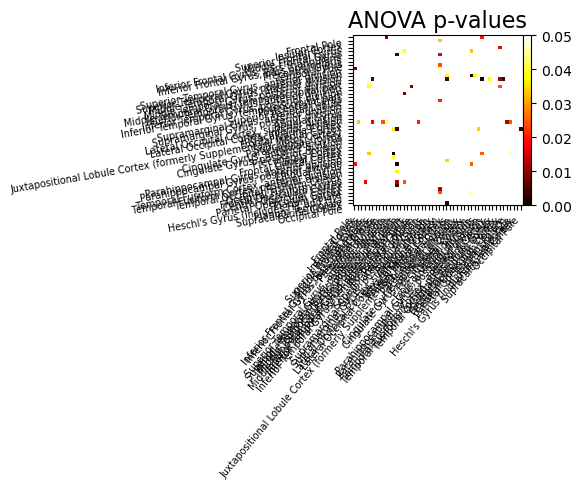

In [138]:
# transform the p-value results into a square matrix
anova_matrix = np.zeros((number_of_regions, number_of_regions))

for i in range(number_of_regions):
    for j in range(number_of_regions):
        anova_matrix[i,j] = results[i * number_of_regions + j]['PR(>F)'][0]

# Plot the p-values
plotting.plot_matrix(anova_matrix, labels=labels[1:], vmax=0.05, vmin=0, title='ANOVA p-values', cmap='hot')

# num of connections with p-value < 0.05
num_sig_conn = np.sum(anova_matrix < 0.05)

# conn matrix only with significant results
sig_conn_matrix = np.ones((number_of_regions, number_of_regions))*0.05

for i in range(number_of_regions):
    for j in range(number_of_regions):
        if results[i * number_of_regions + j]['PR(>F)'][0] < 0.05:
            sig_conn_matrix[i,j] = results[i * number_of_regions + j]['PR(>F)'][0]
        




In [155]:
# Get rows and columns with p-values less than 0.05
rows= []
cols = []

idx= 0

anova_1D_matrix = {}
for i in range(number_of_regions):
    for j in range(number_of_regions):
        if anova_matrix[i,j] < 0.01:
            rows.append(i)
            cols.append(j)
            anova_1D_matrix[idx] = anova_matrix[i,j]

            idx += 1



arr_rows = np.array(rows)
arr_cols = np.array(cols)

anova_1D_matrix = np.array(list(anova_1D_matrix.values()))




In [156]:
import mne_connectivity

from mne_connectivity.viz import plot_connectivity_circle

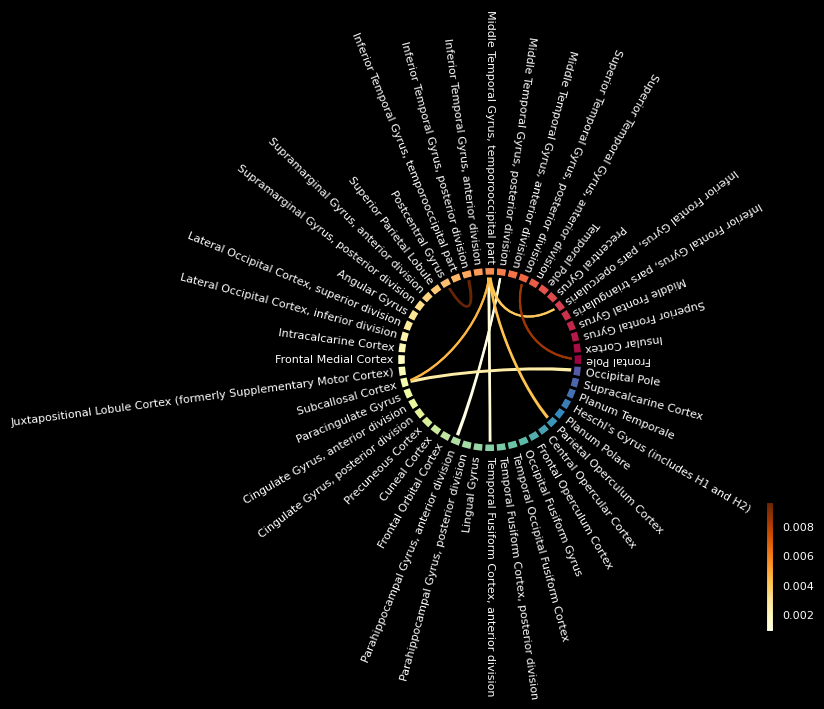

In [157]:
# Plot circle plot highlighting the connections that show significant differences between classes

conn_plot=plot_connectivity_circle(anova_1D_matrix, labels[1:], indices=(arr_rows, arr_cols), colormap='YlOrBr', facecolor='black', textcolor='white')


In [158]:
conn_plot[0].savefig(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-FCMVPA_anova-circle-plot.png'))